# Stock Market Data Visualization

The Stock Market is an extremely important part of the financial sector of any developed country, proving its overall stability, prosperity and forecasted opportunities. Therefore, visualizing this crucial dataset, even in realtime, can lead to more informed decisions, either in investing possibilities or other ventures.

For the United States of America, stock market data is available for free at [Kaggle](https://www.kaggle.com/datasets/paultimothymooney/stock-market-data), being refreshed weekly. The dataset contains many indices, but for our purposes we'll look only at the S&P 500, the most followed equity indicator, tracking the performance of 500 large companies listed on stock exchanges in the United States.

Once downloaded, the dataset includes a file for every company listed in the S&P 500, each of them being in the CSV format. Let's see how such a file looks like!

In [31]:
import numpy as np
import pandas as pd
import datetime

str2date = lambda x: datetime.datetime.strptime(x.decode("utf-8"), "%d-%m-%Y")

stock = np.genfromtxt(
    fname="./data/AAPL.csv",
    delimiter=",",
    skip_header=1,
    dtype=None,
    usecols=(0, 1, 2, 3, 4, 5),
    names="Date,Low,Open,Volume,High,Close",
    converters={0: str2date}
)

df = pd.DataFrame(stock)
print(df)

            Date         Low        Open     Volume        High       Close
0     1980-12-12    0.128348    0.128348  469033600    0.128906    0.128348
1     1980-12-15    0.121652    0.122210  175884800    0.122210    0.121652
2     1980-12-16    0.112723    0.113281  105728000    0.113281    0.112723
3     1980-12-17    0.115513    0.115513   86441600    0.116071    0.115513
4     1980-12-18    0.118862    0.118862   73449600    0.119420    0.118862
...          ...         ...         ...        ...         ...         ...
10411 2022-03-29  176.339996  176.690002  100589400  179.009995  178.960007
10412 2022-03-30  176.699997  178.550003   92633200  179.610001  177.770004
10413 2022-03-31  174.399994  177.839996  103049300  178.029999  174.610001
10414 2022-04-01  171.940002  174.029999   78699800  174.880005  174.309998
10415 2022-04-04  174.440002  174.570007   35051793  178.210007  177.519806

[10416 rows x 6 columns]


We see that each line includes the date of when the stock was traded, along with financial information such as:
- the lowest price-point during trading (`Low`)
- the opening price of the stock (`Open`)
- the volume of the stock, which is simply the number of shares traded (`Volume`)
- the highest price-point during trading (`High`)
- the close price (`Close`)

Normally, when making financial decisions, we want to invest in companies that performed well historically, hoping that the same trend will be followed in the future. Therefore, we would want a comparison between the companies listed in the S&P 500, in order to see how they performed.

In [32]:
import matplotlib.pyplot as plt
import inspect
import os

def load_data(stock_symbols):
    """
    Loads data into pandas dataframes
    :param stock_symbols: [str]
    :return: [[str, dataframe]], where:
        - str is the stock symbol
        - dataframe is a pandas dataframe containing the corresponding stock data
    """

    func_name = inspect.stack()[0][3]

    # check if input is list
    if type(stock_symbols) != list:
        raise TypeError("[{}]: expected list of strings as input".format(func_name))

    # check if all symbols are valid
    for symbol in stock_symbols:
        symbol = symbol.upper()
        if not os.path.isfile("./data/{}.csv".format(symbol)):
            raise ValueError("[{}]: {} stock symbol not found".format(func_name, symbol))

    # lambda function to convert np string to datetime
    str2date = lambda x: datetime.datetime.strptime(x.decode("utf-8"), "%d-%m-%Y")

    # load data in pandas dataframes
    dataframes = []
    for symbol in stock_symbols:
        symbol = symbol.upper()
        stock = np.genfromtxt(
            fname="./data/{}.csv".format(symbol),
            delimiter=",",
            skip_header=1,
            dtype=None,
            usecols=(0, 1, 2, 3, 4, 5),
            names="Date,Low,Open,Volume,High,Close",
            converters={0: str2date}
        )

        df = pd.DataFrame(stock)

        dataframes.append([symbol, df])

    return dataframes

def compare_stocks(stock_symbols, start_date=None, tick_spacing=None):
    """
    Plots chart with closing prices of the stocks.
    :param stock_symbols: [str], list of stock symbols
    :param start_date: str, date from which plotting will be done, with format of ""%d-%m-%Y"
    :param tick_spacing: int, tick spacing for the Y axis
    """
    dataframes = load_data(stock_symbols)

    for df in dataframes:
        # filter if start_date is specifies
        if start_date is not None:
            start_date: datetime.datetime.strptime(start_date, "%d-%m-%Y")
            df[1] = df[1][df[1]["Date"] > start_date]

    # plot stocks
    fig, ax = plt.subplots()
    ax.grid(True)
    fig.set_dpi(200)
    fig.set_size_inches(20, 10)

    for df in dataframes:
        dates = df[1].iloc[:, 0]
        prices = df[1].iloc[:, 1]

        ax.plot(dates, prices, label=df[0])

    # set tick spacing for Y axis, if specified
    if tick_spacing is not None and type(tick_spacing) == int:
        plt.gca().yaxis.set_major_locator(plt.MultipleLocator(tick_spacing))

    # draw plot
    plt.xlabel("Date")
    plt.ylabel("Stock Prices (USD)")
    plt.legend()
    plt.show()

The `compare_stocks` function above allows us to chart the historical closing prices one company...

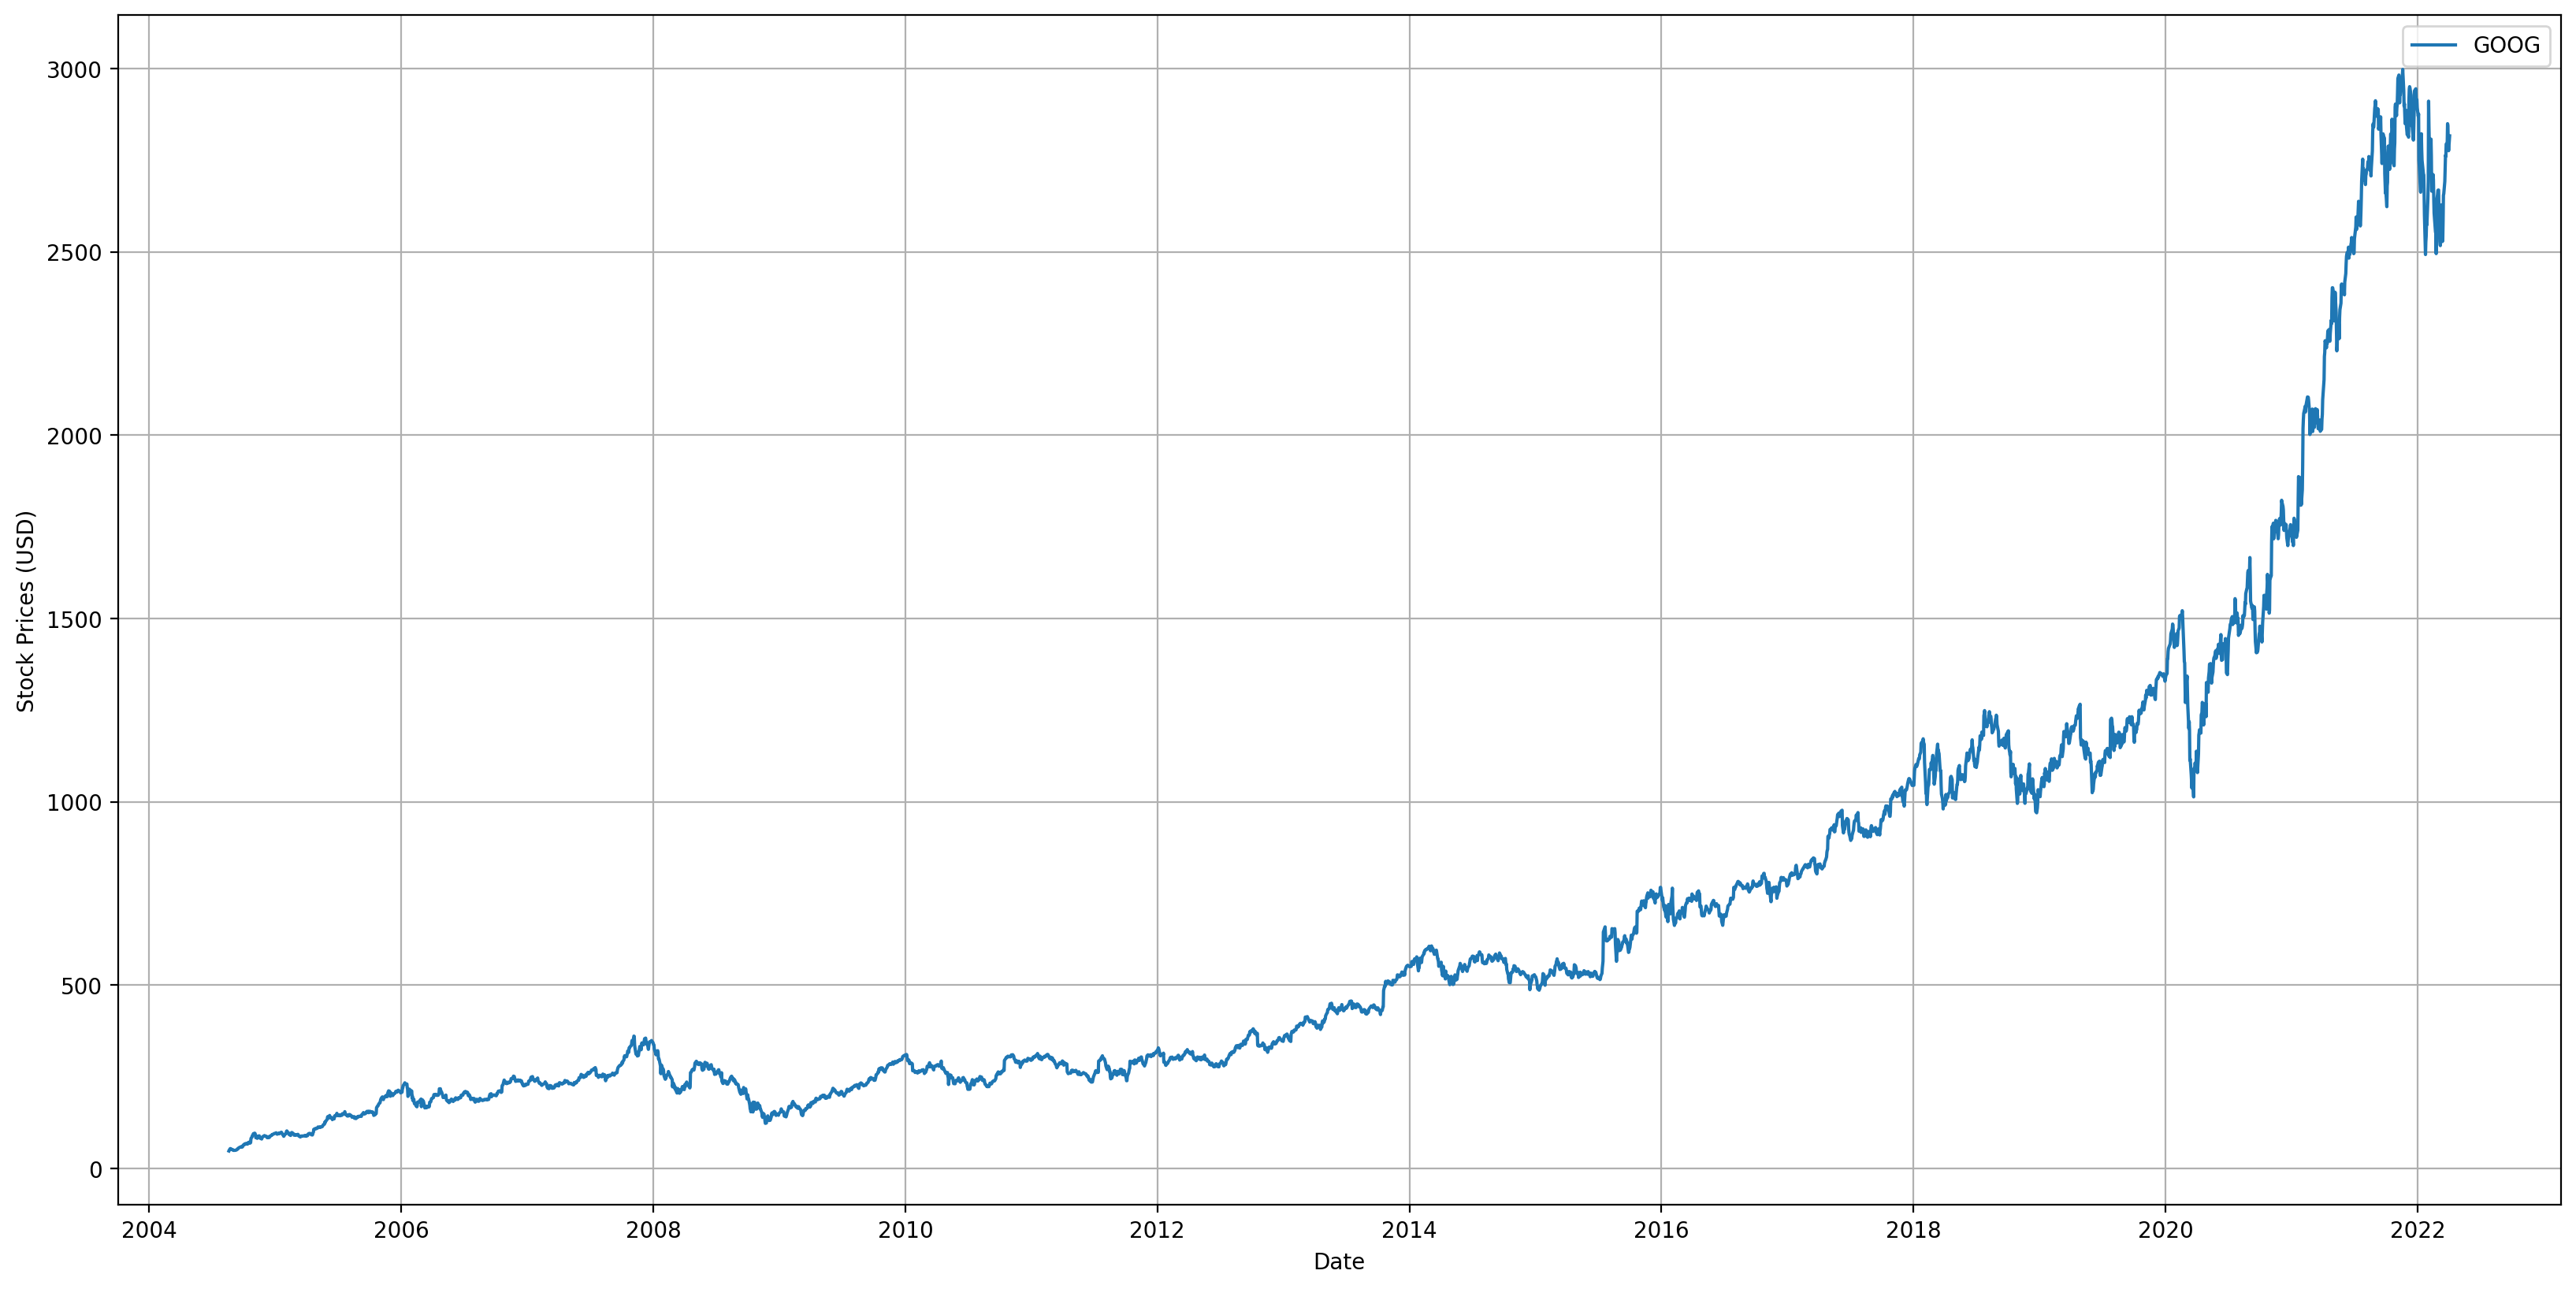

In [33]:
compare_stocks(["goog"])

... or more companies!

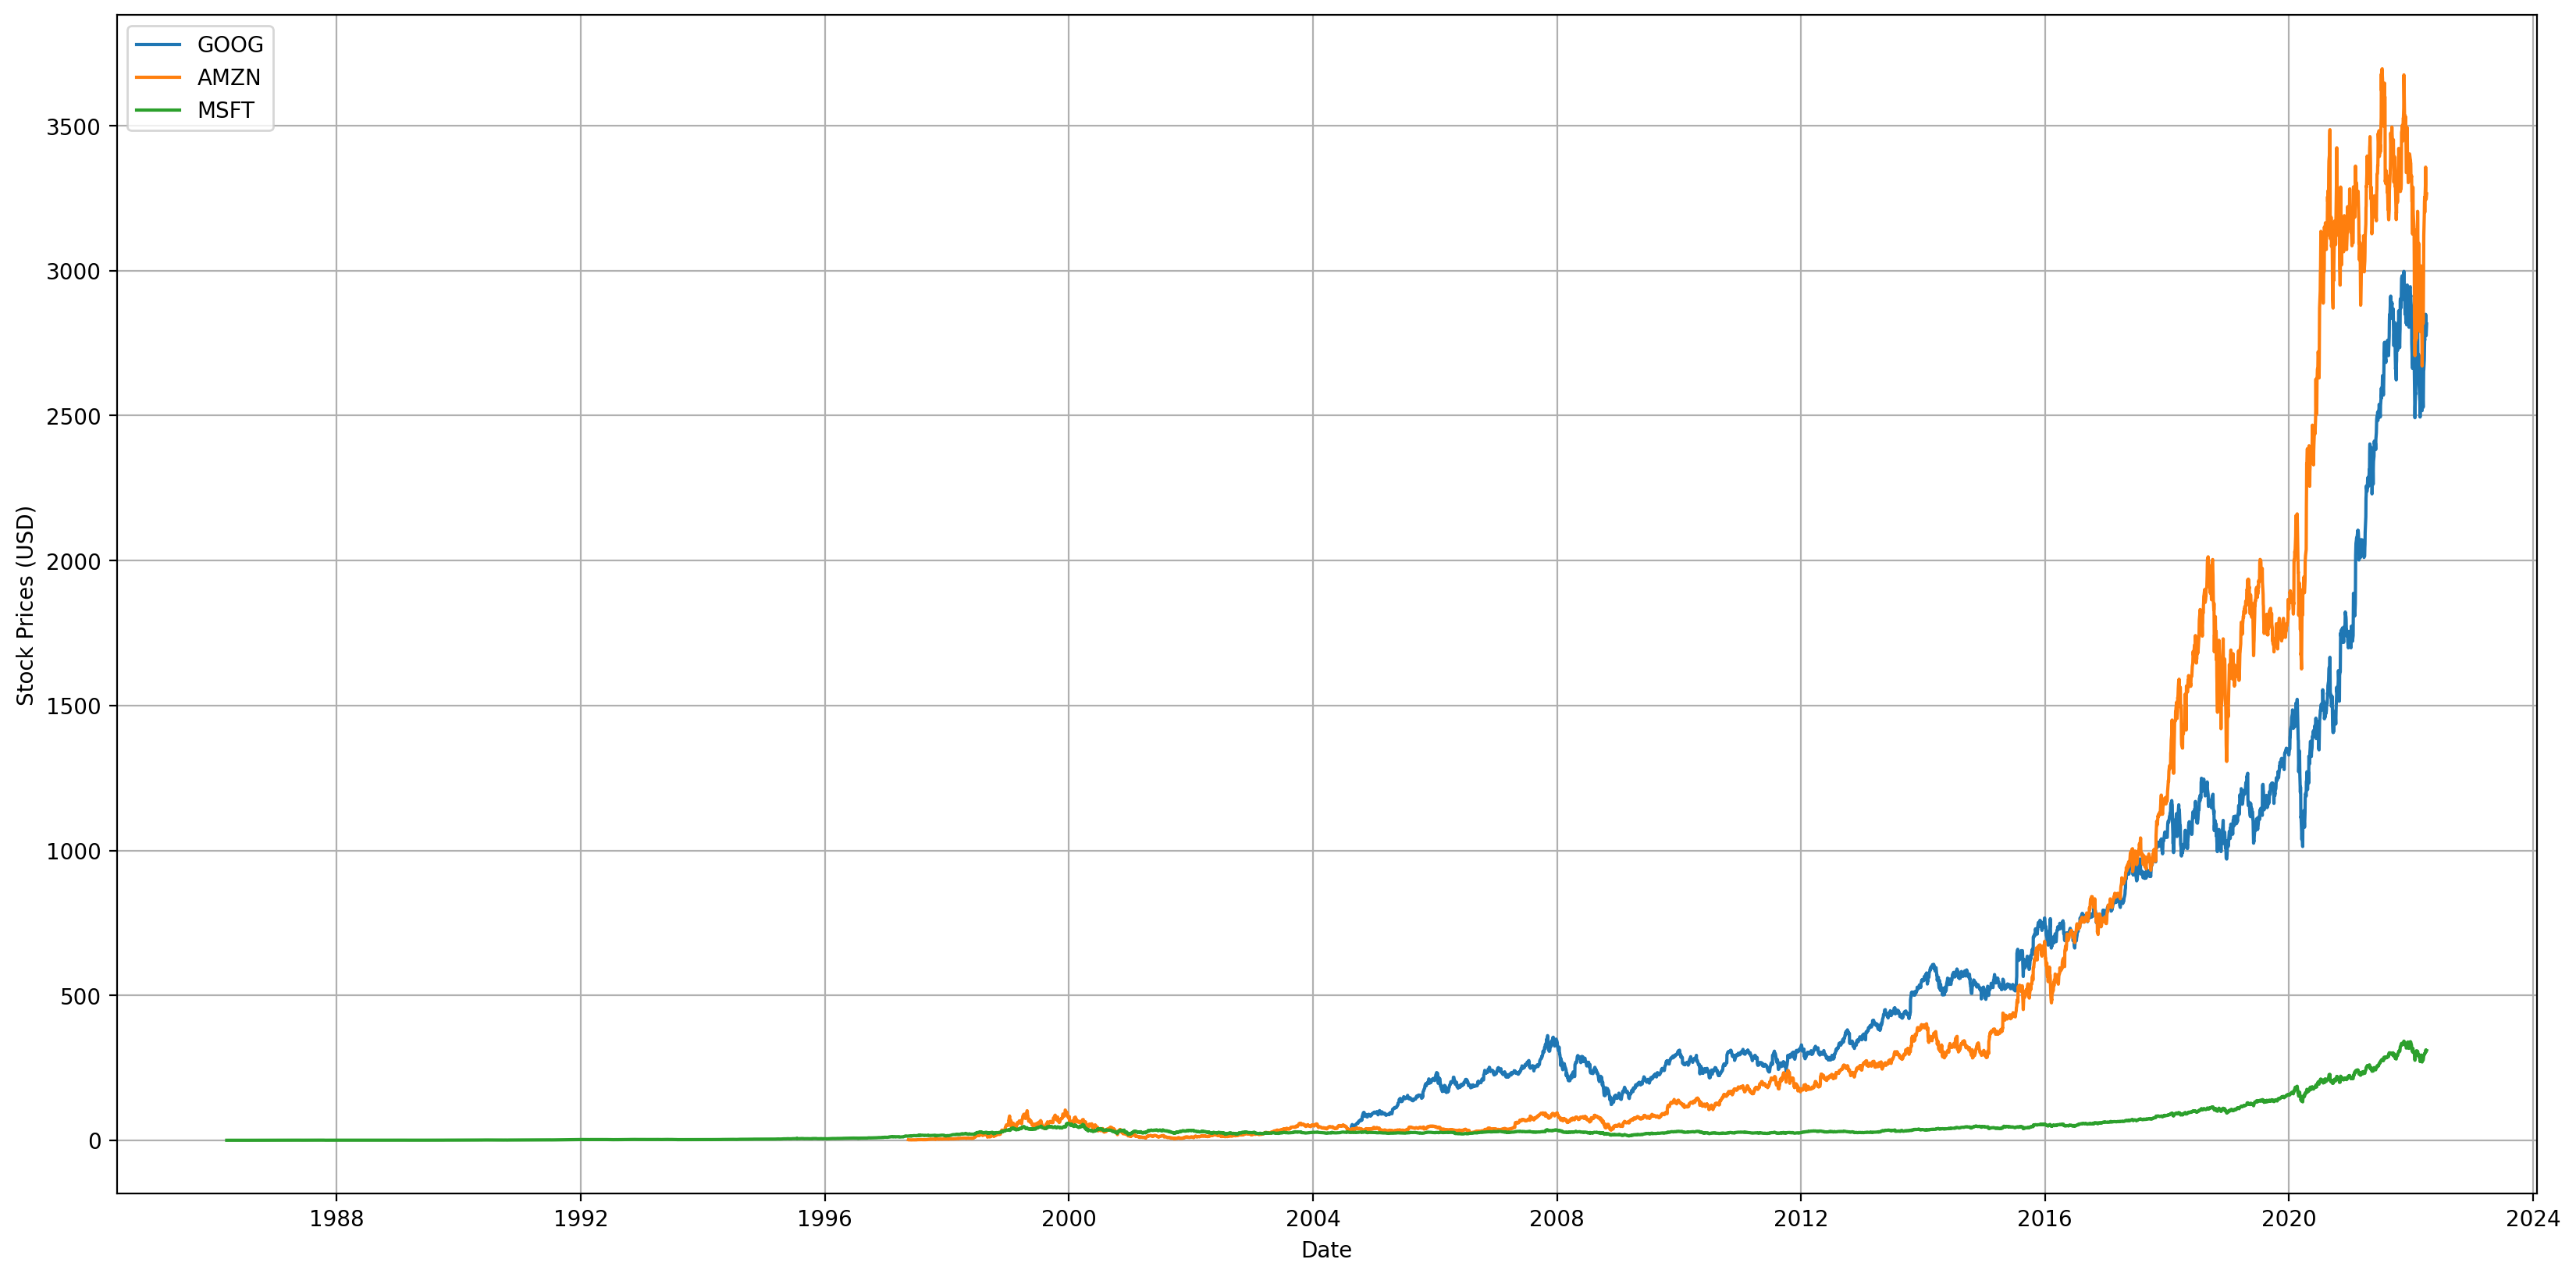

In [34]:
compare_stocks(["goog", "amzn", "msft"])

We can also choose a starting date, in case we want the data to be more focused on recent events:

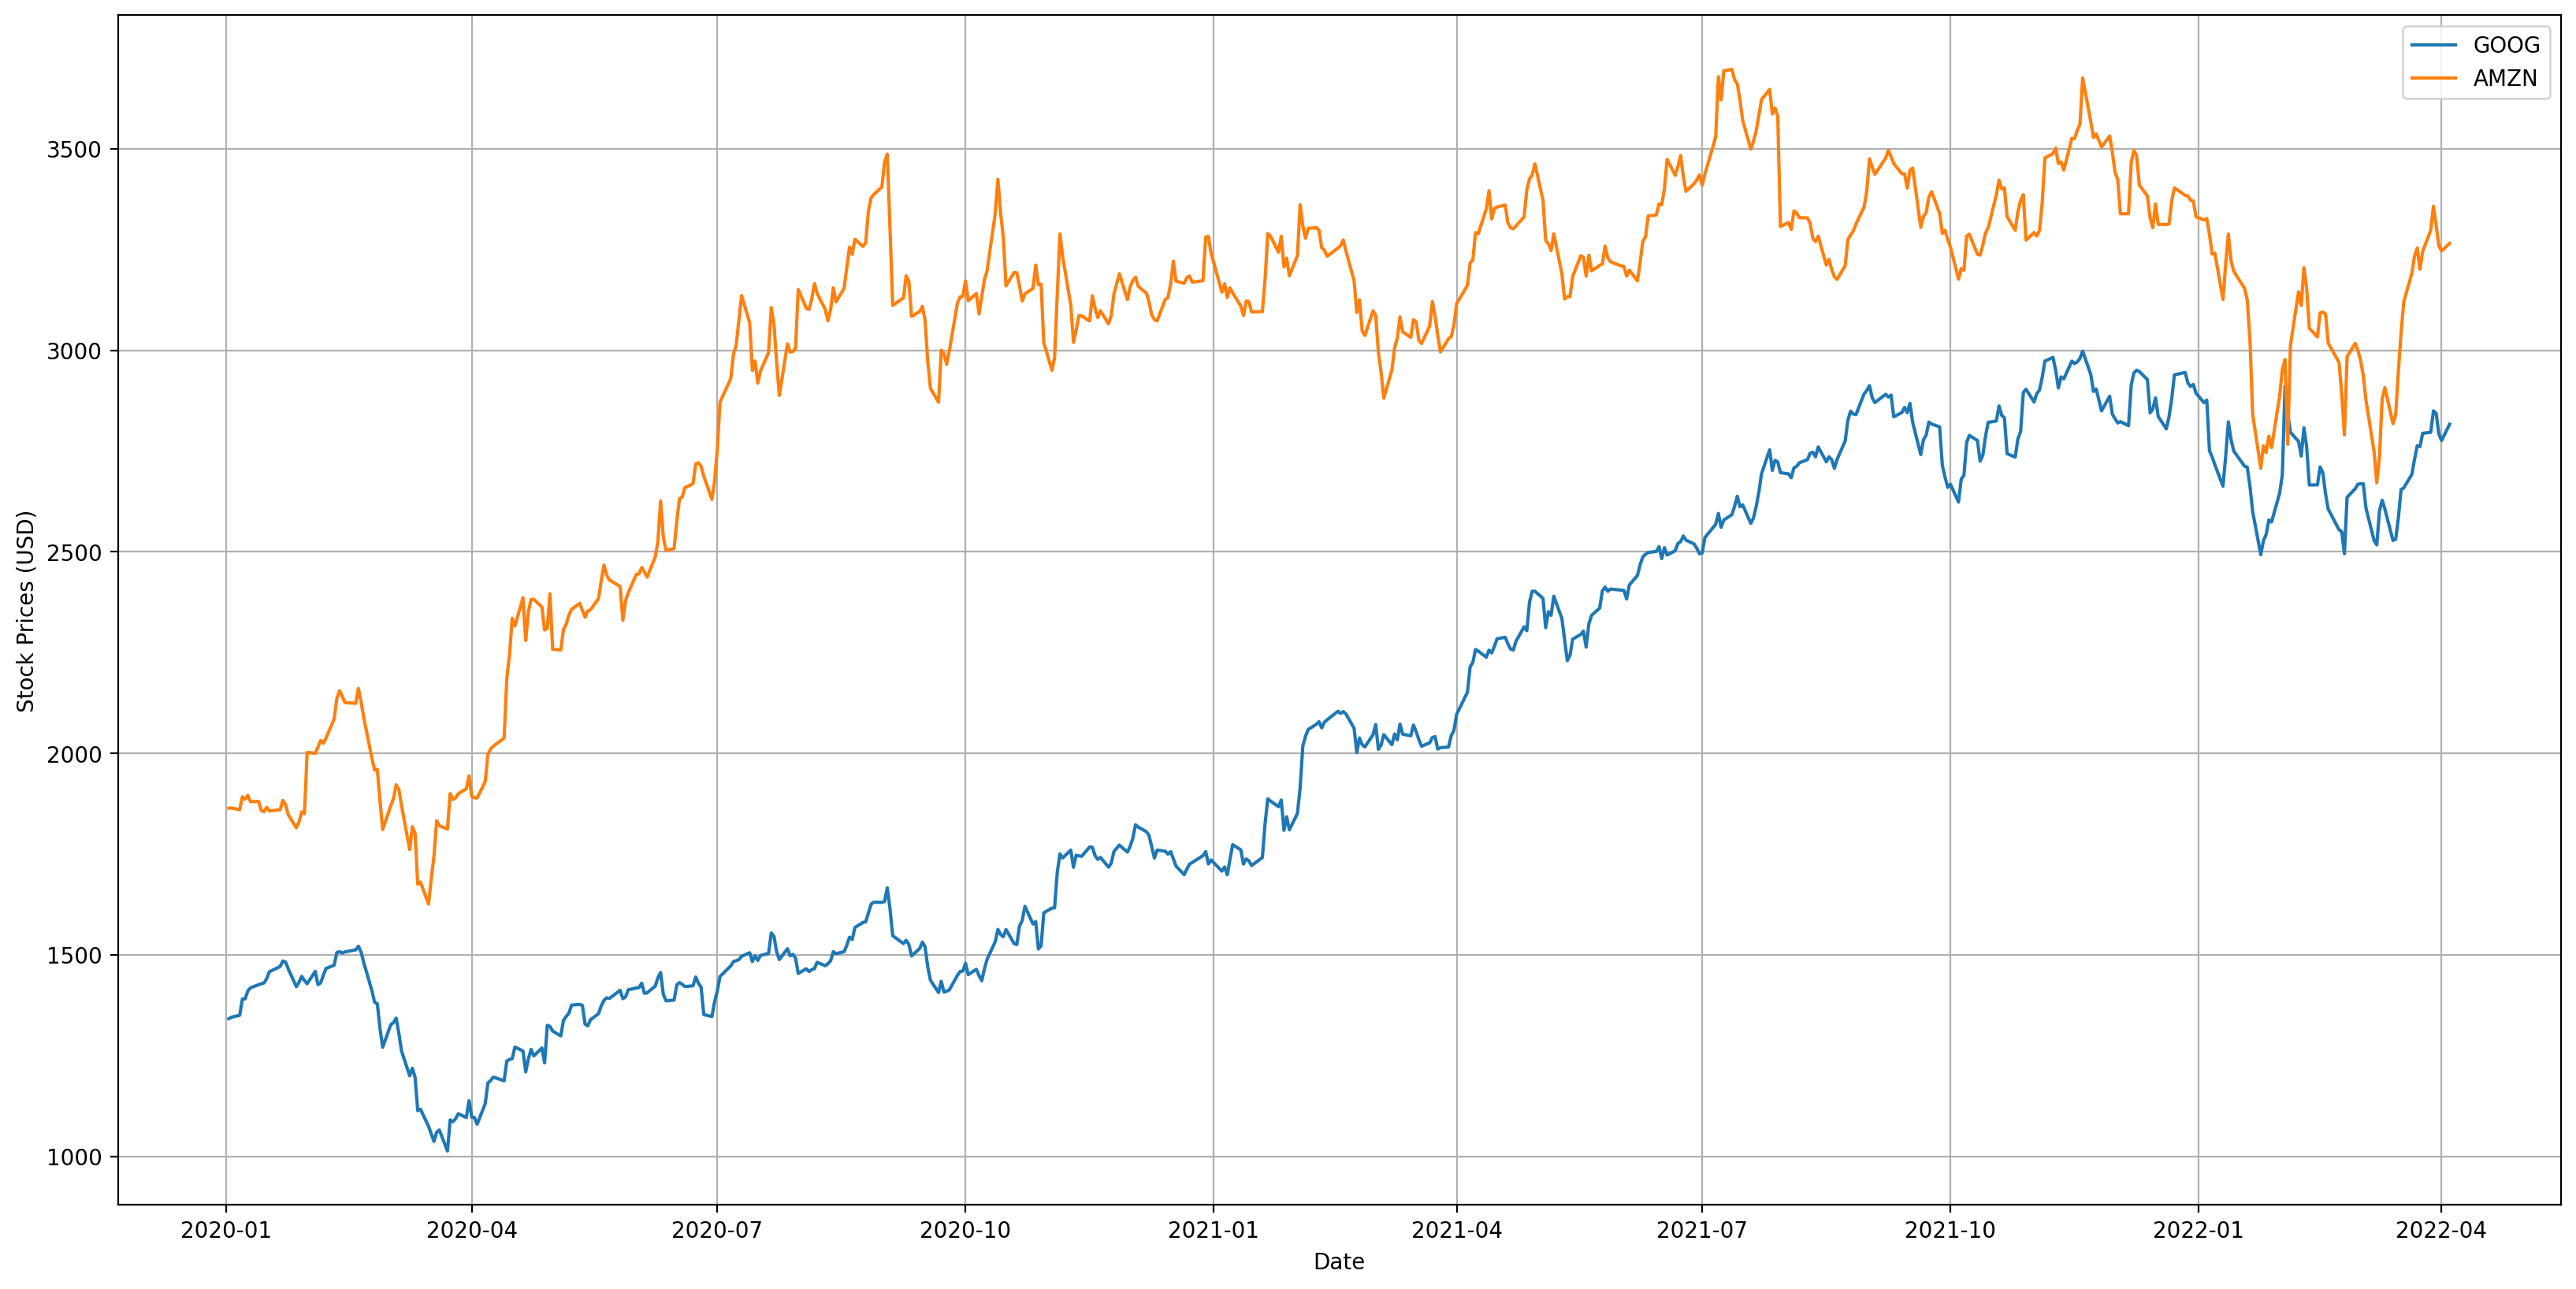

In [35]:
compare_stocks(["goog", "amzn"], start_date="01-01-2020")

However, in the plot above, is hard to distinguish exact price-points. For that, we can use the `tick_spacing` parameter:

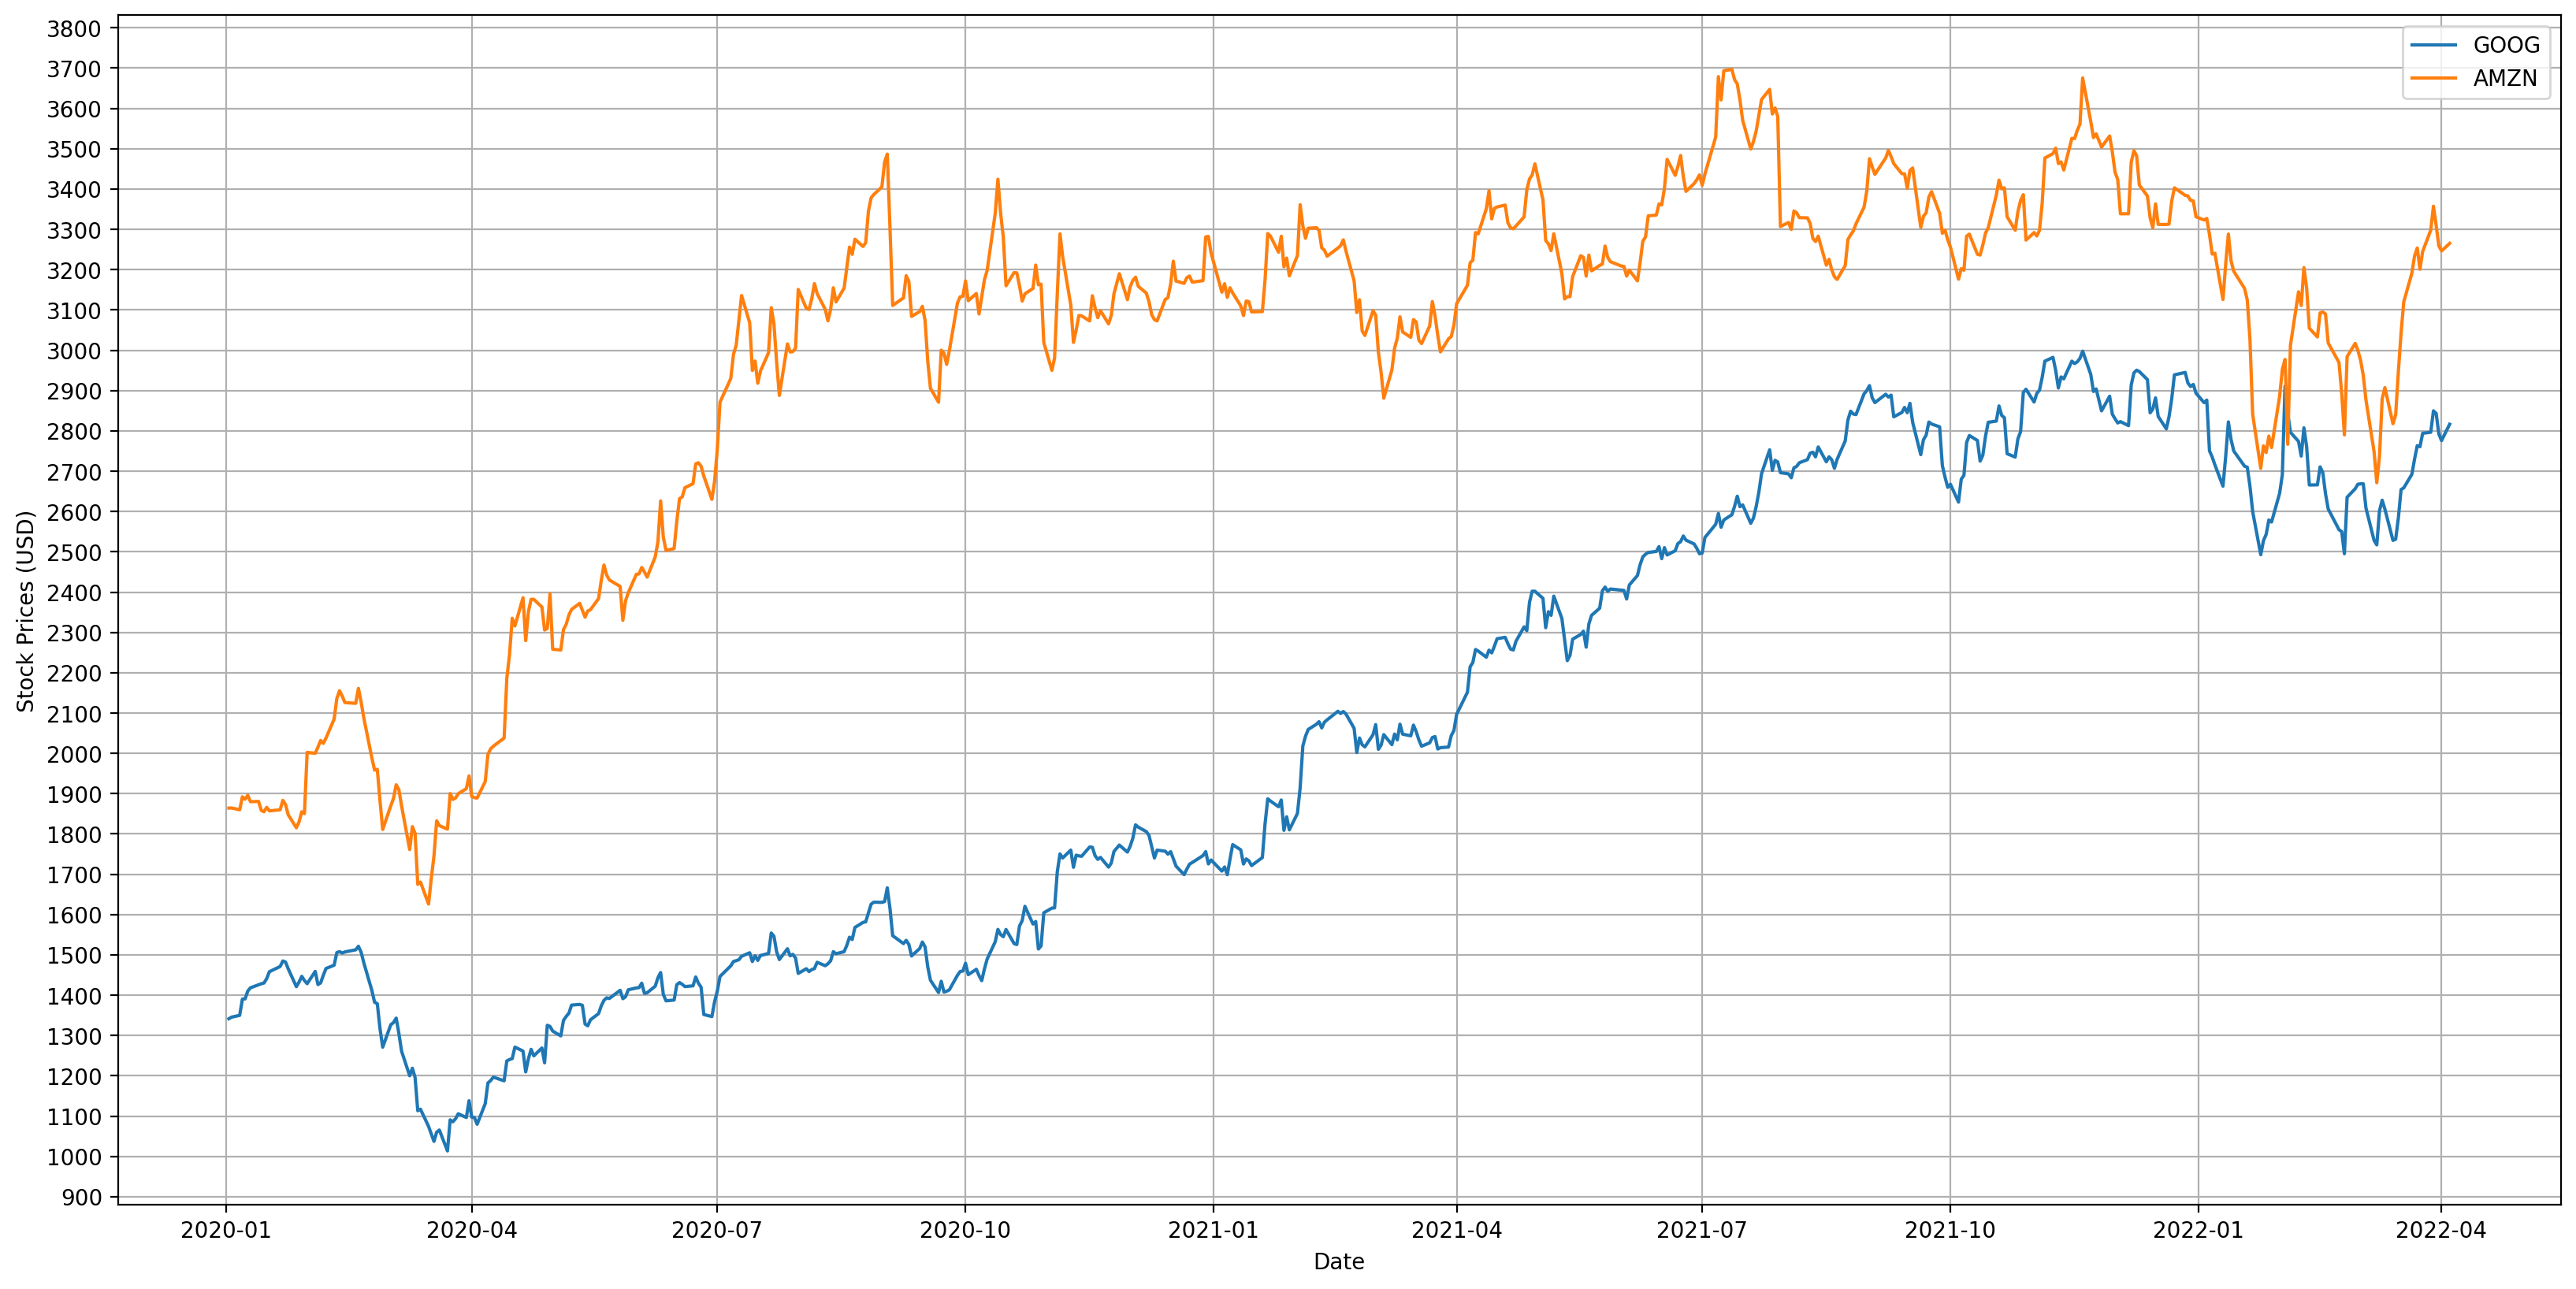

In [36]:
compare_stocks(["goog", "amzn"], start_date="01-01-2020", tick_spacing=100)

However, when investing in the whole S&P 500 index, you automatically invest in all the companies in it. However, since the index is weighted by market cap, companies that are worth more are a bigger part of the index. Therefore, it would be useful to see which are the biggest companies by market share in the S&P 500.

In [37]:
def donut():
    """
    Plots a donut chart with the first 10 companies by market cap.
    """
    files = [f.strip(".csv") for f in os.listdir("./data") if os.path.isfile(os.path.join("./data", f))]

    # get last closing price for each stock
    data = []
    for symbol in files:
        stock = np.genfromtxt(
            fname="./data/{}.csv".format(symbol),
            delimiter=",",
            skip_header=1,
            dtype=None,
            usecols=(5),
            names="Close",
        )

        df = pd.DataFrame(stock).iloc[-1].astype(float).round(1)

        if not pd.isna(df["Close"]):
            if symbol != "BRK-A":
                # outlier
                data.append([symbol, df["Close"].astype(int)])

    # sort by stock prices
    data.sort(key=lambda x: x[1], reverse=True)

    # select only first 10 companies
    data = data[0:10]

    # plot
    plt.figure(dpi=200)
    plt.pie([e[1] for e in data], labels=[e[0] for e in data], autopct='%1.1f%%', startangle=90,
            textprops=dict(fontsize=6))
    plt.axis('equal')
    plt.title("Top 10 Stocks by Market Price", loc="left")
    plt.show()

/var/folders/kg/3_1s_gs93tsf4zx2b7lgw4k40000gn/T/ipykernel_9411/2989235138.py:10: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  stock = np.genfromtxt(


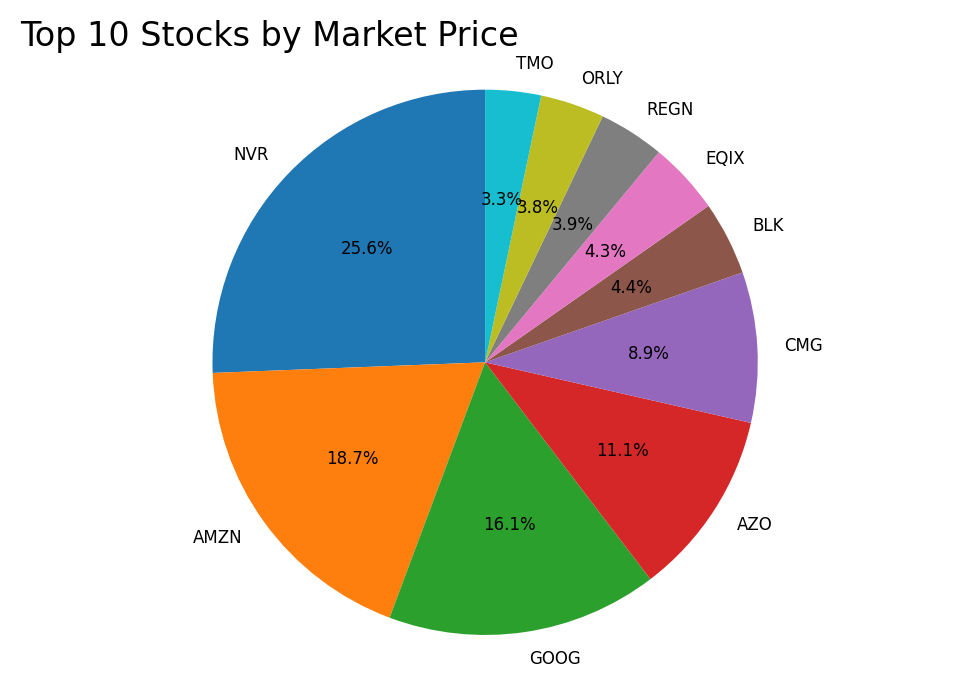

In [38]:
donut()

Here, we can see the top 10 companies of the S&P 500, along with their corresponding percentage. NVR Inc., Amazon and Google are the top companies here.

However, stock analysts do not rely on long historical data, or the most recent closing price. In a trading day, they use all the indicators, including the opening price, the closing price, the lowest price and the highest price to decide when a trade should be places. The most common plot used for trading securities is called the Candlestick Chart.

In [39]:
def candlestick(symbol, start_date, end_date):
    """
    Plots a candlestick chart for the given stock symbol.
    :param symbol: company symbol for which to plot the chart
    :param start_date: start date of the plot
    :param end_date: end date of the plot
    """
    str2date = lambda x: datetime.datetime.strptime(x.decode("utf-8"), "%d-%m-%Y")
    stock = np.genfromtxt(
        fname="./data/{}.csv".format(symbol.upper()),
        delimiter=",",
        skip_header=1,
        dtype=None,
        usecols=(0, 1, 2, 4, 5),
        names="Date,Low,Open,High,Close",
        converters={0: str2date}
    )

    df = pd.DataFrame(stock)

    # restrict to one week of the start_date
    start_date = datetime.datetime.strptime(start_date, "%d-%m-%Y")
    end_date = datetime.datetime.strptime(end_date, "%d-%m-%Y")

    # extract prices for the given week
    mask_dates = (df['Date'] > start_date) & (df['Date'] <= end_date)
    df = df[mask_dates]

    # create figure
    plt.figure()
    plt.figure().set_dpi(200)
    plt.figure().set_size_inches(20, 10)
    plt.grid(True, axis="y")
    plt.gca().yaxis.set_major_locator(plt.MultipleLocator(20))

    # define width of candlestick elements
    width = .4
    width2 = .05

    # define up and down prices
    up = df[df["Close"] >= df["Open"]]
    down = df[df["Close"] < df["Open"]]

    # plot up prices
    plt.bar(up["Date"], up["Close"] - up["Open"], width, bottom=up["Open"], color="green")
    plt.bar(up["Date"], up["High"] - up["Close"], width2, bottom=up["Close"], color="green")
    plt.bar(up["Date"], up["Low"] - up["Open"], width2, bottom=up["Open"], color="green")

    # plot down prices
    plt.bar(down["Date"], down["Close"] - down["Open"], width, bottom=down["Open"], color="red")
    plt.bar(down["Date"], down["High"] - down["Open"], width2, bottom=down["Open"], color="red")
    plt.bar(down["Date"], down["Low"] - down["Close"], width2, bottom=down["Close"], color="red")

    # rotate x-axis tick labels
    plt.xticks(rotation=45, ha='right')

    # display candlestick chart
    plt.show()

<Figure size 432x288 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

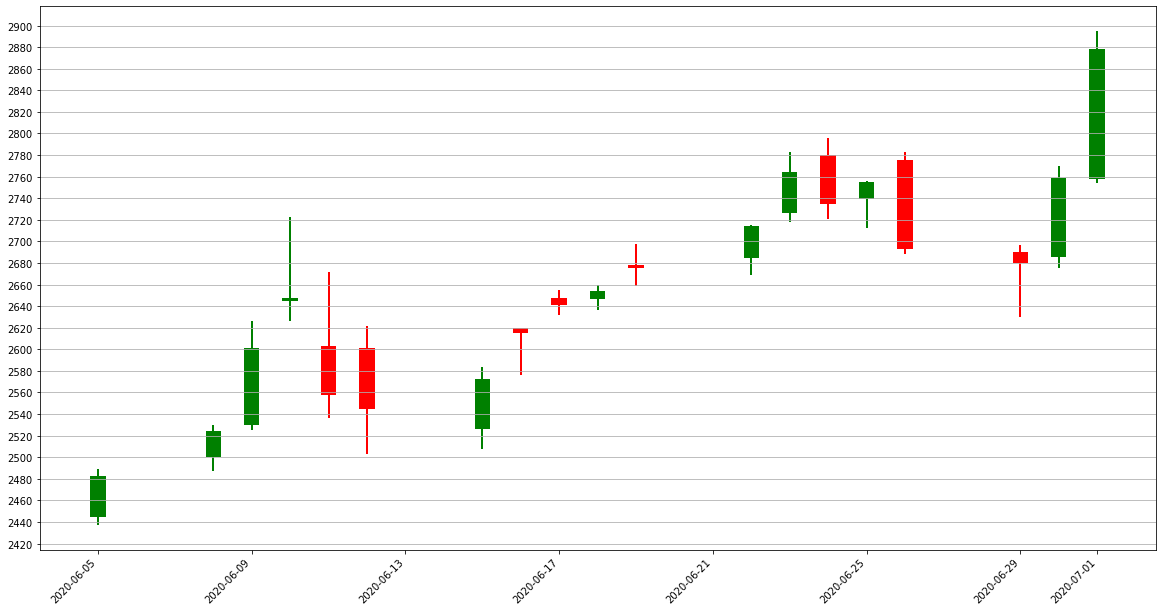

In [40]:
candlestick("amzn", "04-06-2020", "01-07-2020")

<Figure size 432x288 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

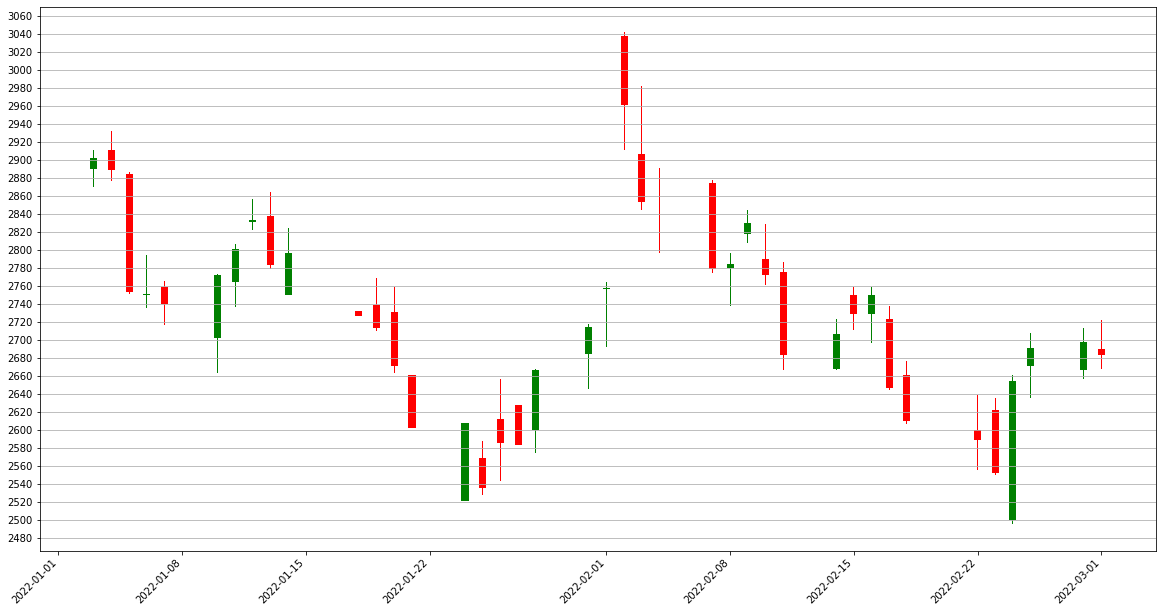

In [41]:
candlestick("goog", "01-01-2022", "01-03-2022")